# L5: Fast AI Agents with a Semantic Cache

In this final lab, you’ll integrate your semantic cache into an AI agent so it can reuse past results, skip redundant work, and get faster over time.

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

In [1]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

## Setup Environment

In [2]:
from cache.llm_evaluator import set_openai_key

set_openai_key()

In [3]:
import logging
import time
import json
import numpy as np
import pandas as pd
from datetime import datetime
from typing import List, Dict, Any, Optional

#from langchain.schema import Document
from langchain_core.documents import Document

#from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langgraph.graph import StateGraph, END, START

import redis
from redisvl.utils.vectorize import HFTextVectorizer, OpenAITextVectorizer
from redisvl.extensions.cache.llm import SemanticCache
from redisvl.index import SearchIndex
from redisvl.query import VectorQuery

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s"
)
logger = logging.getLogger("agentic-workflow")

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>
</div>

## Setup Redis Infra

In [4]:
redis_client = redis.Redis.from_url(
    "redis://localhost:6379", decode_responses=False
)
redis_client.ping()

True

### Build the Agent Knowledge Base (for RAG)


In [5]:
from agent import create_knowledge_base_from_texts


embeddings = OpenAITextVectorizer()

raw_docs = [
    "Our premium support plan includes 24/7 phone support, priority email response within 2 hours, and dedicated account management. Premium support costs $49/month.",
    "Account upgrade process: Go to Account Settings → Plan & Billing → Select Upgrade. Available plans: Basic $9/month, Pro $29/month, Enterprise $99/month.",
    "API rate limits by plan: Free tier 100 requests/hour, Basic 1,000 requests/hour, Pro 10,000 requests/hour, Enterprise unlimited with fair-use policy.",
    "Data export options: CSV, JSON, XML formats supported. Large exports (>1GB) may take up to 24 hours to process.",
    "Third-party integrations: Native support for Slack, Microsoft Teams, Zoom, Salesforce, HubSpot. 200+ additional integrations available via Zapier.",
    "Security features: SOC2 compliance, end-to-end encryption, GDPR compliance, SSO integration, audit logs, IP whitelisting.",
    "Billing and payments: We accept all major credit cards, PayPal, and ACH transfers. Enterprise customers can pay by invoice with NET30 terms.",
    "Account recovery: Use forgot password link, verify email, or contact support with account verification details. Response within 4 hours.",
]

success, message, kb_index = create_knowledge_base_from_texts(
    texts=raw_docs,
    source_id="customer_support_docs",
    redis_url="redis://localhost:6379",
    skip_chunking=True
)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:kb-utils:Using provided list of 8 text chunks
INFO:redisvl.index.index:Index already exists, overwriting.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:kb-utils:✅ Created knowledge base 

### Build the Semantic Cache

In [6]:
from cache.wrapper import SemanticCacheWrapper
from cache.config import config
from cache.cross_encoder import CrossEncoder
from cache.faq_data_container import FAQDataContainer

cache = SemanticCacheWrapper.from_config(config)

data = FAQDataContainer()
cache.hydrate_from_df(data.faq_df, clear=True)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: redis/langcache-embed-v1


✅ Redis is running and accessible!


INFO:redisvl.index.index:Index already exists, not overwriting.


Loaded 8 FAQ entries
Loaded 80 test queries


## Build the LangGraph Agent

In [7]:
from agent import (
    WorkflowState,
    initialize_agent,
    decompose_query_node,
    check_cache_node,
    research_node,
    evaluate_quality_node,
    synthesize_response_node,
    route_after_cache_check,
    route_after_quality_evaluation,
)

initialize_agent(cache, kb_index, embeddings)

In [8]:
workflow = StateGraph(WorkflowState)

# Add nodes 
workflow.add_node("decompose_query", decompose_query_node)
workflow.add_node("check_cache", check_cache_node)
workflow.add_node("research", research_node)
workflow.add_node("evaluate_quality", evaluate_quality_node)
workflow.add_node("synthesize", synthesize_response_node)

# Set entry point to decomposition node
workflow.set_entry_point("decompose_query")

# Add edges
workflow.add_edge("decompose_query", "check_cache")
workflow.add_conditional_edges(
    "check_cache",
    route_after_cache_check,
    {
        "research": "research",  # Go to research if cache misses
        "synthesize": "synthesize",  # Skip to synthesis if all cached
    },
)
workflow.add_edge("research", "evaluate_quality")
workflow.add_conditional_edges(
    "evaluate_quality",
    route_after_quality_evaluation,
    {
        "research": "research",
        "synthesize": "synthesize",
    },
)
workflow.add_edge("synthesize", END)

workflow_app = workflow.compile()

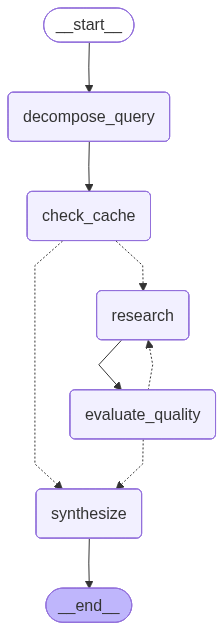

In [9]:
from IPython.display import Image, display

display(Image(workflow_app.get_graph().draw_mermaid_png()))

## Demo the Agent

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output visualizations generated may differ from those shown in the video.</p>

In [10]:
from agent import display_results
from agent import run_agent

### Scenario 1: Enterprise Platform Evaluation (cache building phase)


In [11]:
scenario1_query = """
I'm evaluating your platform for our enterprise needs. We need to understand your 
security and compliance standards including SOC2 status, want to know the API rate 
limits for the Pro plan since we're considering that tier, need details about 
Salesforce integration capabilities, and want to understand your payment options 
including whether you support ACH transfers.
"""

result1 = run_agent(workflow_app, scenario1_query)
display_results(result1)

INFO:agentic-workflow:================================================================================
INFO:agentic-workflow:🧠 Decomposing query...
INFO:agentic-workflow:🧠 Supervisor: Decomposing query: '
I'm evaluating your platform for our enterprise n...'
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:agentic-workflow:🧠 Decomposed into 4 sub-questions in 1012.04ms
INFO:agentic-workflow:   1. What are your security and compliance standards, including your SOC2 status?
INFO:agentic-workflow:   2. What are the API rate limits for the Pro plan?
INFO:agentic-workflow:   3. What are your Salesforce integration capabilities?
INFO:agentic-workflow:   4. What payment options do you offer, and do you support ACH transfers?
INFO:agentic-workflow:🧠 Query decomposition complete
INFO:agentic-workflow:🔍 Supervisor: Checking cache for 4 sub-questions
INFO:agentic-workflow:   ❌ Cache MISS: 'What are your security and compliance st...'
INFO:agentic-wor

\n🎯 SEMANTIC CACHING WORKFLOW ANALYSIS
📝 **Original Query:** 
I'm evaluating your platform for our enterprise needs. We need to understand your 
security and com...
🔄 **Execution Path:** decomposed → cache_checked → researched → quality_evaluated → synthesized
\n🧠 **Query Decomposition:** 4 sub-questions
   1. 🔍 **RESEARCH**: What are your security and compliance standards, including your SOC2 status?
   2. 🔍 **RESEARCH**: What are the API rate limits for the Pro plan?
   3. 🔍 **RESEARCH**: What are your Salesforce integration capabilities?
   4. ✅ **CACHE HIT** (0.888): What payment options do you offer, and do you support ACH transfers?
\n📊 **Performance Metrics:**
   💾 Cache Hit Rate: **25.0%** (1/4 questions)
   🤖 LLM Calls: **8** (GPT-4: 2, GPT-4-Mini: 6)
   ⚡ Total Latency: **14352.04ms**
   ⏱️  Cache: 84ms, Research: 5741ms
\n📋 **AI Response:**
--------------------------------------------------------------------------------


Thank you for considering our platform for your enterprise needs! I’m happy to provide a comprehensive overview addressing your questions about security, API rate limits, Salesforce integration, and payment options.

First, regarding security and compliance, our platform is SOC2 compliant and adheres to robust standards including end-to-end encryption, GDPR compliance, SSO integration, audit logs, and IP whitelisting. If you have any specific requirements or would like more detailed documentation on our security practices, please let me know.

For the Pro plan, the API rate limit is 10,000 requests per hour, which should support most enterprise-level integrations and workflows.

When it comes to Salesforce integration, we offer a range of support. We can guide you on connecting Salesforce with other systems via APIs, help design workflows involving Salesforce data, provide information on Salesforce data models and best practices, assist with code snippets for Salesforce API calls, and advise on tools or middleware to facilitate integration. If you have particular integration scenarios in mind, feel free to share them so we can offer more tailored guidance.

As for payment options, we accept all major credit cards, PayPal, Apple Pay, Google Pay, and bank transfers for orders over $100. This includes support for ACH transfers.

If you need further details on any of these topics or have additional questions, please don’t hesitate to ask. We’re here to help ensure our platform meets your enterprise requirements!

--------------------------------------------------------------------------------


### Scenario 2: Implementation Planning (partial cache hits likely)

In [12]:
scenario2_query = """
We're moving forward with implementation planning. I need to compare API rate limits 
between Pro and Enterprise plans to decide on our tier, confirm the Salesforce 
integration capabilities we discussed, understand what data export options you provide 
for our migration needs, and verify the payment methods including ACH since our 
accounting team prefers that for monthly billing.
"""

result2 = run_agent(workflow_app, scenario2_query)
display_results(result2)

INFO:agentic-workflow:================================================================================
INFO:agentic-workflow:🧠 Decomposing query...
INFO:agentic-workflow:🧠 Supervisor: Decomposing query: '
We're moving forward with implementation planning...'
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:agentic-workflow:🧠 Decomposed into 4 sub-questions in 822.96ms
INFO:agentic-workflow:   1. What are the API rate limits for the Pro and Enterprise plans?
INFO:agentic-workflow:   2. What Salesforce integration capabilities are available?
INFO:agentic-workflow:   3. What data export options are provided for migration purposes?
INFO:agentic-workflow:   4. What payment methods are supported, specifically is ACH available for monthly billing?
INFO:agentic-workflow:🧠 Query decomposition complete
INFO:agentic-workflow:🔍 Supervisor: Checking cache for 4 sub-questions
INFO:agentic-workflow:   ✅ Cache HIT: 'What are the API rate limits for the Pr

\n🎯 SEMANTIC CACHING WORKFLOW ANALYSIS
📝 **Original Query:** 
We're moving forward with implementation planning. I need to compare API rate limits 
between Pro a...
🔄 **Execution Path:** decomposed → cache_checked → researched → quality_evaluated → synthesized
\n🧠 **Query Decomposition:** 4 sub-questions
   1. ✅ **CACHE HIT** (0.947): What are the API rate limits for the Pro and Enterprise plans?
   2. ✅ **CACHE HIT** (0.924): What Salesforce integration capabilities are available?
   3. 🔍 **RESEARCH**: What data export options are provided for migration purposes?
   4. ✅ **CACHE HIT** (0.857): What payment methods are supported, specifically is ACH available for monthly billing?
\n📊 **Performance Metrics:**
   💾 Cache Hit Rate: **75.0%** (3/4 questions)
   🤖 LLM Calls: **4** (GPT-4: 2, GPT-4-Mini: 2)
   ⚡ Total Latency: **9482.33ms**
   ⏱️  Cache: 80ms, Research: 2528ms
\n📋 **AI Response:**
--------------------------------------------------------------------------------


Thank you for outlining your requirements as you move forward with implementation planning. I’m happy to provide a comprehensive overview to help you make the best decision for your team.

For API rate limits, the Pro plan allows up to 10,000 requests per hour. If you anticipate higher usage, the Enterprise plan offers increased limits—please let me know your expected volume, and I can provide more specific details for the Enterprise tier.

Regarding Salesforce integration, we offer robust support in several areas. I can guide you through connecting Salesforce with other systems via APIs, help design workflows involving Salesforce data, provide insights on Salesforce data models and integration best practices, assist with code snippets for API calls, and advise on tools or middleware to streamline the integration process. If you have particular integration scenarios in mind, feel free to share them, and I can offer more targeted guidance.

For your migration needs, we support data exports in CSV, JSON, and XML formats. Please note that exports larger than 1GB may take up to 24 hours to process, so it’s a good idea to plan accordingly if you have substantial data to migrate.

In terms of payment methods, we accept all major credit cards, PayPal, Apple Pay, Google Pay, and bank transfers (ACH) for orders over $100. This should align well with your accounting team’s preference for ACH on monthly billing.

If you need more detailed information on any of these points or have additional questions, please let me know—I’m here to help ensure a smooth implementation process for your team.

--------------------------------------------------------------------------------


### Scenario 3: Pre-Purchase Comprehensive Review (many cache hits expected)

In [13]:
scenario3_query = """
Before finalizing our Pro plan purchase, I need complete validation on: your security 
compliance framework including SOC2 requirements, the exact API rate limits for the 
Pro plan we're purchasing, confirmation of the Salesforce integration features, all 
supported payment methods since we want to use ACH transfers, and your data export 
capabilities for our future migration planning.
"""

result3 = run_agent(workflow_app, scenario3_query)
display_results(result3)

INFO:agentic-workflow:================================================================================
INFO:agentic-workflow:🧠 Decomposing query...
INFO:agentic-workflow:🧠 Supervisor: Decomposing query: '
Before finalizing our Pro plan purchase, I need c...'
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:agentic-workflow:🧠 Decomposed into 4 sub-questions in 1315.35ms
INFO:agentic-workflow:   1. What is your security compliance framework, specifically regarding SOC2 requirements?
INFO:agentic-workflow:   2. What are the exact API rate limits for the Pro plan we are considering?
INFO:agentic-workflow:   3. What Salesforce integration features are included with the Pro plan?
INFO:agentic-workflow:   4. What payment methods do you support, and do you accept ACH transfers?
INFO:agentic-workflow:🧠 Query decomposition complete
INFO:agentic-workflow:🔍 Supervisor: Checking cache for 4 sub-questions
INFO:agentic-workflow:   ✅ Cache HIT: 'What is y

\n🎯 SEMANTIC CACHING WORKFLOW ANALYSIS
📝 **Original Query:** 
Before finalizing our Pro plan purchase, I need complete validation on: your security 
compliance f...
🔄 **Execution Path:** decomposed → cache_checked → researched → quality_evaluated → synthesized
\n🧠 **Query Decomposition:** 4 sub-questions
   1. ✅ **CACHE HIT** (0.958): What is your security compliance framework, specifically regarding SOC2 requirements?
   2. ✅ **CACHE HIT** (0.971): What are the exact API rate limits for the Pro plan we are considering?
   3. 🔍 **RESEARCH**: What Salesforce integration features are included with the Pro plan?
   4. ✅ **CACHE HIT** (0.917): What payment methods do you support, and do you accept ACH transfers?
\n📊 **Performance Metrics:**
   💾 Cache Hit Rate: **75.0%** (3/4 questions)
   🤖 LLM Calls: **4** (GPT-4: 2, GPT-4-Mini: 2)
   ⚡ Total Latency: **7592.76ms**
   ⏱️  Cache: 11ms, Research: 2030ms
\n📋 **AI Response:**
------------------------------------------------------------------

Thank you for reaching out with your detailed questions before finalizing your Pro plan purchase—I'm happy to provide all the information you need.

**Security Compliance:**  
Our platform adheres to robust security and compliance standards, including full SOC2 compliance. We also offer end-to-end encryption, GDPR compliance, SSO integration, audit logs, and IP whitelisting to ensure your data is protected at every level. If you need more specifics about any of these measures, please let me know!

**API Rate Limits:**  
With the Pro plan, you’ll have an API rate limit of 10,000 requests per hour. This should provide ample capacity for most integration and automation needs.

**Salesforce Integration:**  
The Pro plan includes native support for Salesforce integration. You can connect Salesforce directly to our platform without the need for additional connectors, making it easy to sync data and streamline your workflows. The API rate limit mentioned above also applies to integration usage.

**Payment Methods:**  
We support all major credit cards, PayPal, Apple Pay, Google Pay, and bank transfers (ACH) for orders over $100. So, you’ll be able to use ACH transfers for your purchase.

**Data Export Capabilities:**  
Our platform offers comprehensive data export features, allowing you to export your data in standard formats. This ensures you have flexibility for future migration planning or backup purposes.

If you have any further questions or need more detailed documentation on any of these points, please let me know—I'm here to help!

--------------------------------------------------------------------------------


## Agent Performance Analysis


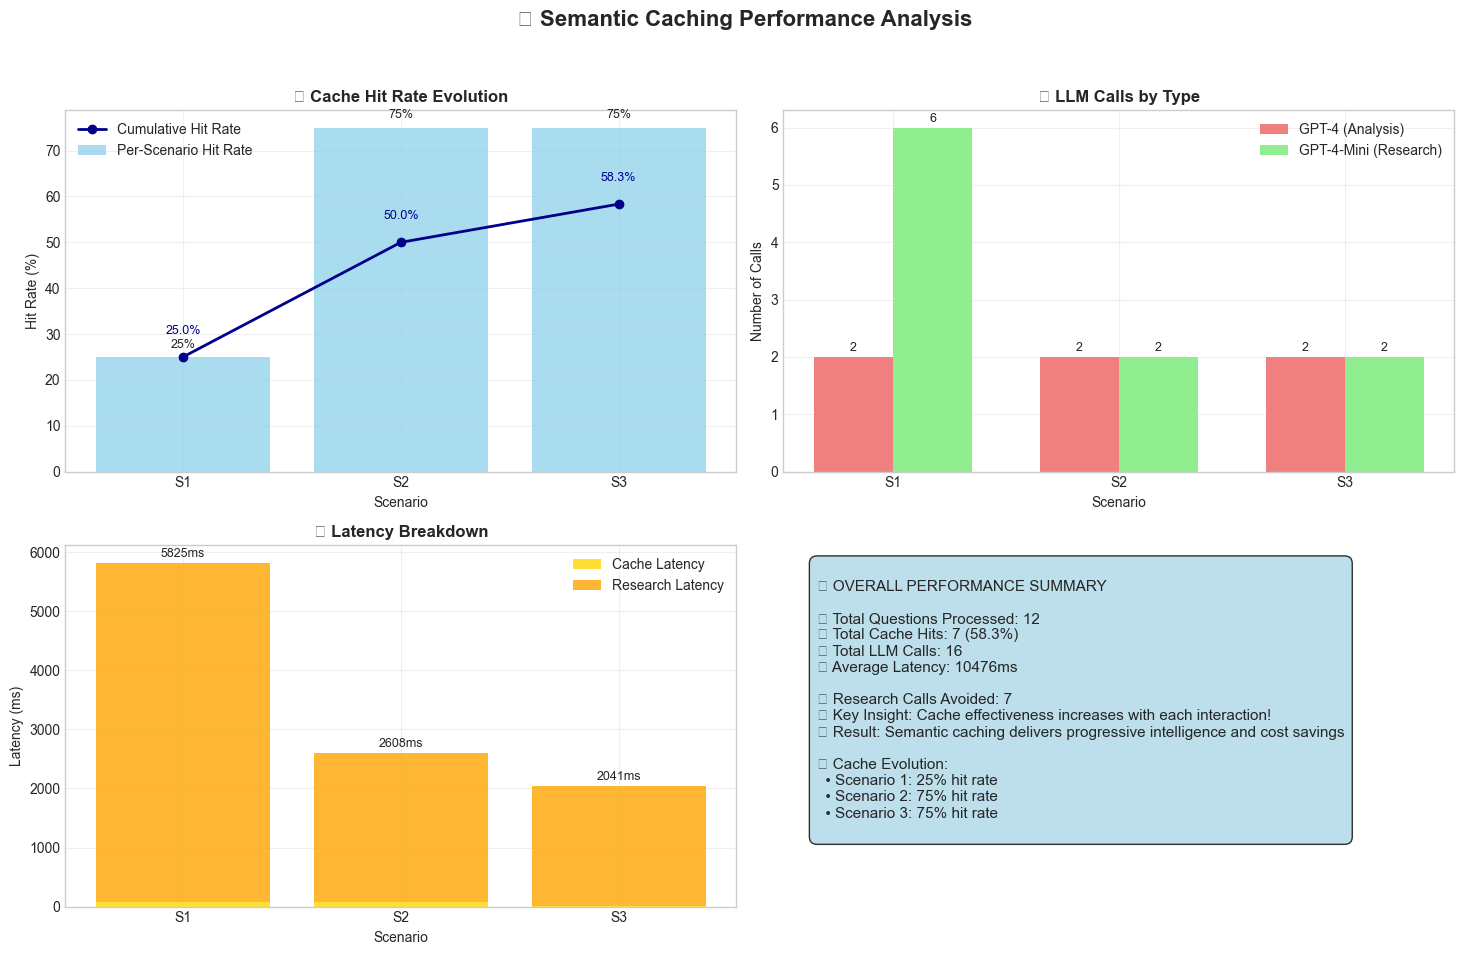

In [14]:
import warnings
warnings.simplefilter("ignore")

from agent import analyze_agent_results

total_questions, total_cache_hits = analyze_agent_results(
    [result1, result2, result3]
)

## Interactive Demo


Here is the link we used in the video for this section:
* https://att.com/international

In [15]:
from agent import launch_demo

launch_demo(
    workflow_app,
    cache,
    share=True,
    height=1500,
    inline=True
)

INFO:demo:Using Tavily API key from environment
INFO:httpx:HTTP Request: GET http://127.0.0.1:7860/gradio_api/startup-events "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7860/ "HTTP/1.1 200 OK"


* Running on local URL:  http://127.0.0.1:7860


INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.gradio.app/v3/tunnel-request "HTTP/1.1 200 OK"
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


* Running on public URL: https://e4afde1b25d3628c7d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


INFO:httpx:HTTP Request: HEAD https://e4afde1b25d3628c7d.gradio.live "HTTP/1.1 200 OK"


In [ ]:
cache.cache.check(
    "checking cache", distance_threshold=1.0, num_results=100
)